In [1]:
import pyspark
sc = pyspark.SparkContext('local[*]')

In [2]:
!rm -rf metastore_db/*.lck # deletes locks

from pyspark.sql import SQLContext
sqlc = SQLContext(sc)

### Step 1
- Load the train and test sets
- Check the schema, the variables have their right types?
- If not, how to correctly load the datasets?

In [3]:
### INSERT YOUR CODE HERE
df_train = sqlc.read.format('com.databricks.spark.csv')\
    .option('header', 'true')\
    .option('inferschema', 'true')\
    .load('train.csv')
    
df_test = sqlc.read.format('com.databricks.spark.csv')\
    .option('header', 'true')\
    .option('inferschema', 'true')\
    .load('test.csv')
    
df_train.printSchema()
df_train.show()

df_test.printSchema()
df_test.show()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| null|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|   

In [4]:
# Alternative Scheme:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType

customSchema = StructType([StructField("PassengerId", IntegerType(), True),
                           StructField("Survived", DoubleType(), True),
                           StructField("Pclass", IntegerType(), True),
                           StructField("Name", StringType(), True),
                           StructField("Sex", StringType(), True),
                           StructField("Age", DoubleType(), True),
                           StructField("SibSp", IntegerType(), True),
                           StructField("Parch", IntegerType(), True),
                           StructField("Ticket", StringType(), True),
                           StructField("Fare", DoubleType(), True),
                           StructField("Cabin", StringType(), True),
                           StructField("Embarked", StringType(), True)])

customSchema2 = StructType([StructField("PassengerId", IntegerType(), True),
                           StructField("Pclass", IntegerType(), True),
                           StructField("Name", StringType(), True),
                           StructField("Sex", StringType(), True),
                           StructField("Age", DoubleType(), True),
                           StructField("SibSp", IntegerType(), True),
                           StructField("Parch", IntegerType(), True),
                           StructField("Ticket", StringType(), True),
                           StructField("Fare", DoubleType(), True),
                           StructField("Cabin", StringType(), True),
                           StructField("Embarked", StringType(), True)])

train = sqlc.read.csv("train.csv", header=True, schema=customSchema)
test = sqlc.read.csv("test.csv", header=True, schema=customSchema2)

# OR
from handyspark.sql import generate_schema
generate_schema({'PassengerId': int,
                 'Survived': bool,
                 'Pclass': int,
                 'Name': str,
                 'Sex': str,
                 'Age': int,
                 'SibSp': int,
                 'Parch': int,
                 'Ticket': str,
                 'Fare': float,
                 'Cabin': str,
                 'Embarked': str},
               nullable_columns='all')

ModuleNotFoundError: No module named 'handyspark'

### Step 2
- Explore the features of your dataset
- You can use DataFrame's ***describe*** method to get summary statistics
    - hint: ***toPandas*** may be useful to ease the manipulation of small dataframes
- Are there any ***NaN*** values in your dataset?
- If so, define value/values to fill these ***NaN*** values
    - hint: ***na*** property of DataFrames provide several methods of handling NA values

In [5]:
### INSERT YOUR CODE HERE
df_train.describe(["PassengerId", "Survived", "Pclass", "Name", "Sex", "Age"]).show()
df_train.describe(["SibSp", "Parch", "Ticket", "Fare", "Cabin", "Embarked"]).show()

df_test.describe(["PassengerId", "Pclass", "Name", "Sex", "Age"]).show()
df_test.describe(["SibSp", "Parch", "Ticket", "Fare", "Cabin", "Embarked"]).show()

+-------+-----------------+-------------------+------------------+--------------------+------+------------------+
|summary|      PassengerId|           Survived|            Pclass|                Name|   Sex|               Age|
+-------+-----------------+-------------------+------------------+--------------------+------+------------------+
|  count|              891|                891|               891|                 891|   891|               714|
|   mean|            446.0| 0.3838383838383838| 2.308641975308642|                null|  null| 29.69911764705882|
| stddev|257.3538420152301|0.48659245426485753|0.8360712409770491|                null|  null|14.526497332334035|
|    min|                1|                  0|                 1|"Andersson, Mr. A...|female|              0.42|
|    max|              891|                  1|                 3|van Melkebeke, Mr...|  male|              80.0|
+-------+-----------------+-------------------+------------------+--------------------+-

In [6]:
from pyspark.sql.functions import isnan, isnull, when, count, col
df_train.select([count(when(isnull(c), c)).alias(c) for c in df_train.columns]).show()
df_train.select([count(when(isnan(c), c)).alias(c) for c in df_train.columns]).show()

+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|       0|     0|   0|  0|177|    0|    0|     0|   0|  687|       2|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+

+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|       0|     0|   0|  0|  0|    0|    0|     0|   0|    0|       0|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+



In [7]:
df_train_summary = df_train.na.drop(how='any').describe()
#df_train_summary.show()
uniformMean = float(df_train_summary.rdd.collect()[1][6])
#print(uniformMean)
df_train = df_train.na.fill({'Age': uniformMean})
df_train = df_train.na.drop(how='all',subset=['Embarked'])

In [8]:
df_train.select([count(when(isnull(c), c)).alias(c) for c in df_train.columns]).show()

+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|       0|     0|   0|  0|  0|    0|    0|     0|   0|  687|       0|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+



In [9]:
df_test.select([count(when(isnull(c), c)).alias(c) for c in df_test.columns]).show()
df_test.select([count(when(isnan(c), c)).alias(c) for c in df_test.columns]).show()
df_test_summary = df_test.na.drop(how='any').describe()
df_test_summary.show()
uniformMeanAge = float(df_test_summary.rdd.collect()[1][5])
uniformMeanFare = float(df_test_summary.rdd.collect()[1][9])
print(uniformMeanAge)
print(uniformMeanFare)
df_test = df_test.na.fill({'Age': uniformMean, "Fare": uniformMeanFare})
df_test = df_test.na.drop(how='all',subset=['Embarked'])
df_test.select([count(when(isnull(c), c)).alias(c) for c in df_test.columns]).show()

+-----------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|     0|   0|  0| 86|    0|    0|     0|   1|  327|       0|
+-----------+------+----+---+---+-----+-----+------+----+-----+--------+

+-----------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|     0|   0|  0|  0|    0|    0|     0|   0|    0|       0|
+-----------+------+----+---+---+-----+-----+------+----+-----+--------+

+-------+------------------+------------------+--------------------+------+------------------+------------------+------------------+-----------------+-----------------+-----+--------+
|summary|       PassengerId|            Pclass|                Name|   Sex|         

In [ ]:
# Daniels code
# Calculating summary statistics and turning it into Pandas DF
train_desc = train.describe().toPandas().set_index('summary')

# Computing correlations between Survived and some features
print({col:train.stat.corr('Survived',col) for col in ['Pclass','Age','SibSp','Parch','Fare']})

# Checking which columns have NULL values
print({col:train.where(train[col].isNull()).count() for col in train.columns})

# Taking the mean age from the Pandas DF
ageMean = float(train_desc.loc['mean']['Age'])
print(ageMean)

# Filling the Age in both train and test datasets
trainFilled = train.na.fill({'Age': ageMean, 'Embarked': 'S'})
testFilled = test.na.fill({'Age': ageMean, 'Embarked': 'S'})

from pyspark.sql import functions as F
train.groupby('Sex','PClass').agg(F.mean('age')).show()

### Step 3
- How to handle categorical features?
    - hint: check the Estimators and Transformers
- Assemble all desired features into a Vector using the VectorAssembler Transformer
- Make sure to end up with a DataFrame with two columns: ***Survived*** and ***vFeatures***

In [15]:
from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator
from pyspark.ml.feature import VectorAssembler
#from pyspark.mllib.util import MLUtils

#df_train.show()

indexer_sex = StringIndexer().setInputCol("Sex").setOutputCol("index_Sex") # .setHandleInvalid(True)
indexed_sex = indexer_sex.fit(df_train).transform(df_train)
#indexed_sex.show()

indexer_embarked = StringIndexer().setInputCol("Embarked").setOutputCol("index_Embarked") # .setHandleInvalid(True)
indexed_embarked = indexer_embarked.fit(indexed_sex).transform(indexed_sex)
indexed_embarked.show()

+-----------+--------+------+--------------------+------+----------------+-----+-----+----------------+-------+-----+--------+---------+--------------+
|PassengerId|Survived|Pclass|                Name|   Sex|             Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|index_Sex|index_Embarked|
+-----------+--------+------+--------------------+------+----------------+-----+-----+----------------+-------+-----+--------+---------+--------------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|            22.0|    1|    0|       A/5 21171|   7.25| null|       S|      0.0|           0.0|
|          2|       1|     1|Cumings, Mrs. Joh...|female|            38.0|    1|    0|        PC 17599|71.2833|  C85|       C|      1.0|           1.0|
|          3|       1|     3|Heikkinen, Miss. ...|female|            26.0|    0|    0|STON/O2. 3101282|  7.925| null|       S|      1.0|           0.0|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|            35.0|    1|    0|  

In [19]:
indexer_sex_test = StringIndexer().setInputCol("Sex").setOutputCol("index_Sex") # .setHandleInvalid(True)
indexed_sex_test = indexer_sex.fit(df_test).transform(df_test)
#indexed_sex.show()

indexer_embarked_test = StringIndexer().setInputCol("Embarked").setOutputCol("index_Embarked") # .setHandleInvalid(True)
indexed_embarked_test = indexer_embarked_test.fit(indexed_sex_test).transform(indexed_sex_test)
indexed_embarked_test.show()

+-----------+------+--------------------+------+----------------+-----+-----+----------------+-------+-----+--------+---------+--------------+
|PassengerId|Pclass|                Name|   Sex|             Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|index_Sex|index_Embarked|
+-----------+------+--------------------+------+----------------+-----+-----+----------------+-------+-----+--------+---------+--------------+
|        892|     3|    Kelly, Mr. James|  male|            34.5|    0|    0|          330911| 7.8292| null|       Q|      0.0|           2.0|
|        893|     3|Wilkes, Mrs. Jame...|female|            47.0|    1|    0|          363272|    7.0| null|       S|      1.0|           0.0|
|        894|     2|Myles, Mr. Thomas...|  male|            62.0|    0|    0|          240276| 9.6875| null|       Q|      0.0|           2.0|
|        895|     3|    Wirz, Mr. Albert|  male|            27.0|    0|    0|          315154| 8.6625| null|       S|      0.0|           0.0|

In [21]:
encoder = OneHotEncoderEstimator(inputCols=["index_Sex", "index_Embarked", "Pclass"],
                                 outputCols=["vector_Sex", "vector_Embarked", "vector_Pclass"])
model = encoder.fit(indexed_embarked)
encoded = model.transform(indexed_embarked)
encoded.show()

+-----------+--------+------+--------------------+------+----------------+-----+-----+----------------+-------+-----+--------+---------+--------------+-------------+---------------+-------------+
|PassengerId|Survived|Pclass|                Name|   Sex|             Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|index_Sex|index_Embarked|   vector_Sex|vector_Embarked|vector_Pclass|
+-----------+--------+------+--------------------+------+----------------+-----+-----+----------------+-------+-----+--------+---------+--------------+-------------+---------------+-------------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|            22.0|    1|    0|       A/5 21171|   7.25| null|       S|      0.0|           0.0|(1,[0],[1.0])|  (2,[0],[1.0])|    (3,[],[])|
|          2|       1|     1|Cumings, Mrs. Joh...|female|            38.0|    1|    0|        PC 17599|71.2833|  C85|       C|      1.0|           1.0|    (1,[],[])|  (2,[1],[1.0])|(3,[1],[1.0])|
|          3|       

In [22]:
encoder = OneHotEncoderEstimator(inputCols=["index_Sex", "index_Embarked", "Pclass"],
                                 outputCols=["vector_Sex", "vector_Embarked", "vector_Pclass"])
model = encoder.fit(indexed_embarked_test)
encoded_test = model.transform(indexed_embarked_test)
encoded_test.show()

+-----------+------+--------------------+------+----------------+-----+-----+----------------+-------+-----+--------+---------+--------------+-------------+---------------+-------------+
|PassengerId|Pclass|                Name|   Sex|             Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|index_Sex|index_Embarked|   vector_Sex|vector_Embarked|vector_Pclass|
+-----------+------+--------------------+------+----------------+-----+-----+----------------+-------+-----+--------+---------+--------------+-------------+---------------+-------------+
|        892|     3|    Kelly, Mr. James|  male|            34.5|    0|    0|          330911| 7.8292| null|       Q|      0.0|           2.0|(1,[0],[1.0])|      (2,[],[])|    (3,[],[])|
|        893|     3|Wilkes, Mrs. Jame...|female|            47.0|    1|    0|          363272|    7.0| null|       S|      1.0|           0.0|    (1,[],[])|  (2,[0],[1.0])|    (3,[],[])|
|        894|     2|Myles, Mr. Thomas...|  male|            62.0|

In [23]:
assembler_train = VectorAssembler(inputCols = ["vector_Sex", "vector_Embarked", "vector_Pclass", "Age", "SibSp", "Parch"], outputCol = "vFeatures")
assembler_test = VectorAssembler(inputCols = ["vector_Sex", "vector_Embarked", "vector_Pclass", "Age", "SibSp", "Parch"], outputCol = "vFeatures")

In [27]:
df_Vec_train = assembler_train.transform(encoded)
df_Vec_test = assembler_test.transform(encoded_test)

In [32]:
df_Vec_train = df_Vec_train.select([c for c in df_Vec_train.columns if c in ['vFeatures','Survived']])
df_Vec_train.show()
df_Vec_test = df_Vec_test.select([c for c in df_Vec_test.columns if c in ['vFeatures','Survived']])
df_Vec_test.show()

+--------+--------------------+
|Survived|           vFeatures|
+--------+--------------------+
|       0|(9,[0,1,6,7],[1.0...|
|       1|(9,[2,4,6,7],[1.0...|
|       1|(9,[1,6],[1.0,26.0])|
|       1|(9,[1,4,6,7],[1.0...|
|       0|(9,[0,1,6],[1.0,1...|
|       0|(9,[0,6],[1.0,35....|
|       0|(9,[0,1,4,6],[1.0...|
|       0|[1.0,1.0,0.0,0.0,...|
|       1|(9,[1,6,8],[1.0,2...|
|       1|(9,[2,5,6,7],[1.0...|
|       1|(9,[1,6,7,8],[1.0...|
|       1|(9,[1,4,6],[1.0,1...|
|       0|(9,[0,1,6],[1.0,1...|
|       0|[1.0,1.0,0.0,0.0,...|
|       0|(9,[1,6],[1.0,14.0])|
|       1|(9,[1,5,6],[1.0,1...|
|       0|(9,[0,6,7,8],[1.0...|
|       1|(9,[0,1,5,6],[1.0...|
|       0|(9,[1,6,7],[1.0,3...|
|       1|(9,[2,6],[1.0,35....|
+--------+--------------------+
only showing top 20 rows

+--------------------+
|           vFeatures|
+--------------------+
|(9,[0,6],[1.0,34.5])|
|(9,[1,6,7],[1.0,4...|
|(9,[0,5,6],[1.0,1...|
|(9,[0,1,6],[1.0,1...|
|(9,[1,6,7,8],[1.0...|
|(9,[0,1,6],[1.0,1...|

In [34]:
#df_Vec_train.toPandas()

In [ ]:
# Daniels code
from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator
from pyspark.ml.feature import VectorAssembler

# Applying Estimators and Transformators
# Here, I actually fitted and transformed them on the training data
# with the purpose of being able to check the intermediate steps

indexer1 = (StringIndexer()
           .setInputCol("Embarked")
           .setOutputCol("nEmbarked")
           .setHandleInvalid('skip'))

indexed1 = indexer1.fit(trainFilled).transform(trainFilled)

indexer2 = (StringIndexer()
           .setInputCol("Sex")
           .setOutputCol("nSex")
           .setHandleInvalid('skip'))

indexed2 = indexer2.fit(indexed1).transform(indexed1)

encoder1 = OneHotEncoder().setInputCol("nEmbarked").setOutputCol("vEmbarked")
encoded1 = encoder1.transform(indexed2)

# Using a VectorAssembler to put together all feature columns
assembler = VectorAssembler(inputCols=['Pclass',
                                       'Age',
                                       'SibSp',
                                       'Parch',
                                       'Fare',
                                       'nSex',
                                       'vEmbarked'],
                            outputCol='vFeatures')

assembled = assembler.transform(encoded1)

# Keeping only the features and label columns to
assembled2 = assembled.select("Survived","vFeatures")

from pyspark.ml.feature import RFormula

rformula = RFormula(formula='Survived ~ Pclass + Age + SibSp + Parch + Fare + Sex + Embarked',
                    featuresCol='vFeatures', labelCol='Survived')
rmodel = rformula.fit(trainFilled)
features = rmodel.transform(trainFilled)
features.select('vFeatures', 'Survived').limit(5).toPandas()

### Step 4
- Apply a normalization Estimator of your choice to the ***features*** vector obtained in Step 3

In [37]:
from pyspark.ml.feature import StandardScaler

scaler2 = StandardScaler().setInputCol("vFeatures").setOutputCol("scaled_vFeatures").setWithStd(True).setWithMean(True)
scaler2Model = scaler2.fit(df_Vec_train)
df_Vec_train_scaled = scaler2Model.transform(df_Vec_train)
scaler2Model = scaler2.fit(df_Vec_test)
df_Vec_test_scaled = scaler2Model.transform(df_Vec_test)

In [38]:
df_Vec_train_scaled.toPandas()[:5]

,Survived,vFeatures,scaled_vFeatures
0,0,"(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 22.0, 1.0, 0.0)","[0.734928336701, 0.616446953898, -0.4824392247..."
1,1,"(0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 38.0, 1.0, 0.0)","[-1.35914631499, -1.62037485025, 2.07046833956..."
2,1,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 26.0, 0.0, 0.0)","[-1.35914631499, 0.616446953898, -0.4824392247..."
3,1,"(0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 35.0, 1.0, 0.0)","[-1.35914631499, 0.616446953898, -0.4824392247..."
4,0,"(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0)","[0.734928336701, 0.616446953898, -0.4824392247..."


In [39]:
df_Vec_test_scaled.toPandas()[:5]

,vFeatures,scaled_vFeatures
0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0)","[0.755024183341, -1.34905889866, -0.5674615384..."
1,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 47.0, 1.0, 0.0)","[-1.32129232085, 0.739484137046, -0.5674615384..."
2,"(1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 62.0, 0.0, 0.0)","[0.755024183341, -1.34905889866, -0.5674615384..."
3,"(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 27.0, 0.0, 0.0)","[0.755024183341, 0.739484137046, -0.5674615384..."
4,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 22.0, 1.0, 1.0)","[-1.32129232085, 0.739484137046, -0.5674615384..."


In [ ]:
# Daniels code
from pyspark.ml.feature import StandardScaler

scaler = (StandardScaler()
          .setInputCol("vFeatures")
          .setOutputCol("scaledFeat")
          .setWithStd(True)
          .setWithMean(True))

scalerModel = scaler.fit(assembled2)
scaled = scalerModel.transform(assembled2)

### Step 5
- Instead of doing transformations on separate steps, put everything together with a Pipeline

In [ ]:
from pyspark.ml.pipeline import Pipeline

### INSERT YOUR CODE HERE

In [ ]:
# Daniels code
from pyspark.ml.pipeline import Pipeline

pipeline = Pipeline(stages=[indexer1,
                            indexer2,
                            encoder1,
                            assembler,
                            scaler])

pipeline = Pipeline(stages=[rformula, scaler])

model = pipeline.fit(trainFilled)
scaled = model.transform(trainFilled)

### Step 6
- Train a classifier of your choice (for instance, Random Forest) using your dataset of LabeledPoints
- Make predictions for the training data
- Use the evaluators to find the Area Under ROC and Accuracy of your model
- How is your model performing? Try to tune its parameters

In [54]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import RandomForestClassificationModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

### INSERT YOUR CODE HERE
rfC = RandomForestClassifier(labelCol='Survived',
                        featuresCol='scaled_vFeatures',
                        numTrees=50)

model = rfC.fit(df_Vec_train_scaled)
predictions = model.transform(df_Vec_train_scaled)

In [40]:
# Daniels code
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.classification import RandomForestClassificationModel, LogisticRegressionModel

# Trains a RF classifier and make predictions
rfC = RandomForestClassifier(labelCol='Survived',
                        featuresCol='scaledFeat',
                        #rawPredictionCol='rf_raw',
                        #probabilityCol='rf_prob',
                        #predictionCol='rf_pred',
                        numTrees=50)

model = rfC.fit(scaled)

predictions = model.transform(scaled)

lr = LogisticRegression(labelCol='Survived',
                        featuresCol='scaledFeat',
                        rawPredictionCol='lr_raw',
                        probabilityCol='lr_prob',
                        predictionCol='lr_pred')
pipeline2 = Pipeline(stages=[rfC, lr])
model2 = pipeline2.fit(scaled)
model2.transform(scaled).limit(5).toPandas()

NameError: name 'scaled' is not defined

In [44]:
!pip install handyspark

    100% |████████████████████████████████| 61kB 182kB/s ta 0:00:01
    100% |████████████████████████████████| 194kB 68kB/s ta 0:00:011
You are using pip version 9.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [55]:
%matplotlib inline
from handyspark.extensions import BinaryClassificationMetrics

bcm = BinaryClassificationMetrics(scoreAndLabels=predictions,
                                  scoreCol='probability',
                                  labelCol='Survived')
bcm.print_confusion_matrix(.5)

Predicted       
                 0      1
Actual 0     500.0   49.0
       1      97.0  243.0

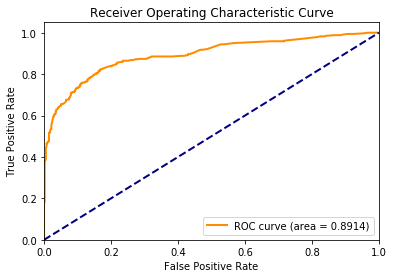

In [56]:
bcm.plot_roc_curve()

### Step 7
- Take a look at the test data - use DataFrame's ***createOrReplaceTempView*** method to perform SQL queries over the data
    - hint: check if there are any NULL values in the dataset - if so, handle them
- Apply the transformations to the test data
    - hint: include the model to the pipeline
- Make predictions using the model previously trained and the transformed test data

In [60]:
### INSERT YOUR CODE HERE
#df_Vec_test_scaled.createOrReplaceTempView("vec_test_scaled_view")
#sqlDF = sqlc.sql("SELECT * FROM vec_test_scaled_view WHERE ")
#sqlDF.show()
# <-- already did the transformations above during conversion of train set
rfC = RandomForestClassifier(labelCol='Survived',
                        featuresCol='scaled_vFeatures',
                        numTrees=50)

model = rfC.fit(df_Vec_train_scaled)
predictions = model.transform(df_Vec_test_scaled)
predictions.show()

+--------------------+--------------------+--------------------+--------------------+----------+
|           vFeatures|    scaled_vFeatures|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+--------------------+----------+
|(9,[0,6],[1.0,34.5])|[0.75502418334112...|[43.2011032107214...|[0.86402206421442...|       0.0|
|(9,[1,6,7],[1.0,4...|[-1.3212923208469...|[26.2712941135463...|[0.52542588227092...|       0.0|
|(9,[0,5,6],[1.0,1...|[0.75502418334112...|[44.2593549098681...|[0.88518709819736...|       0.0|
|(9,[0,1,6],[1.0,1...|[0.75502418334112...|[42.7647727359579...|[0.85529545471915...|       0.0|
|(9,[1,6,7,8],[1.0...|[-1.3212923208469...|[26.7006425809860...|[0.53401285161972...|       0.0|
|(9,[0,1,6],[1.0,1...|[0.75502418334112...|[35.9831013436663...|[0.71966202687332...|       0.0|
|      (9,[6],[30.0])|[-1.3212923208469...|[17.8178019778268...|[0.35635603955653...|       1.0|
|[1.0,1.0,0.0,0.0,...|[0.75502

### Step 8

- Load the answers for the ***test*** data
- Combine it with your predictions into a single DataFrame
- Use the evaluator you created on ***Step 6***
- What was your score?

In [ ]:
### INSERT YOUR CODE HERE